In [ ]:
import torchvision
import torchvision.transforms as transforms

#  the data directory
data_dir = './data'

# a transform to preprocess the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# the CIFAR-10 dataset if it doesn't exist
trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, transform=transform, download=True)
testset = torchvision.datasets.CIFAR10(root=data_dir, train=False, transform=transform, download=True)




100%|██████████| 170498071/170498071 [00:01<00:00, 98266641.18it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
import numpy as np

noise_rate = 0.1

for dataset in [trainset, testset]:
    labels = dataset.targets
    num_samples = len(labels)
    num_corrupted_samples = int(noise_rate * num_samples)
    corrupted_indices = np.random.choice(num_samples, num_corrupted_samples, replace=False)

    for i in corrupted_indices:
        new_label = np.random.randint(0, 10)  #  a random new label
        while new_label == labels[i]:  # the new label is different
            new_label = np.random.randint(0, 10)
        labels[i] = new_label


In [ ]:
import torch

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()  # Add parentheses here
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


#  a data loader for training and testing
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Instantiate the model
net = Net()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Training loop
for epoch in range(10):  # You can adjust the number of epochs
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")

print("Finished Training")

# Evaluation on the test dataset
correct = 0
total = 0

net.eval()

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test dataset: {100 * correct / total:.2f}%")


Epoch 1, Loss: 2.2677363791429173
Epoch 2, Loss: 2.0115373308396403
Epoch 3, Loss: 1.826540326828237
Epoch 4, Loss: 1.7166160270381157
Epoch 5, Loss: 1.6496102915090674
Epoch 6, Loss: 1.5975754350957359
Epoch 7, Loss: 1.551042206756904
Epoch 8, Loss: 1.5078179188396619
Epoch 9, Loss: 1.4660121569853
Epoch 10, Loss: 1.423891769345764
Finished Training
Accuracy on the test dataset: 53.07%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
train_loss_history = []
test_accuracy_history = []

class MentorNet(nn.Module):
    def __init__(self):
        super(MentorNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Instantiate the MentorNet
mentornet = MentorNet()

# Define loss function for MentorNet
mentornet_criterion = nn.CrossEntropyLoss()

# Define optimizer for MentorNet
mentornet_optimizer = optim.SGD(mentornet.parameters(), lr=0.01, momentum=0.9)

# Training loop for MentorNet
mentornet.train()
for epoch in range(10):  # Train MentorNet for a few epochs
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        mentornet_optimizer.zero_grad()
        outputs = mentornet(inputs)
        loss = mentornet_criterion(outputs, labels)
        loss.backward()
        mentornet_optimizer.step()
        running_loss += loss.item()
    print(f"MentorNet Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")

# the MentorNet for fine-tuning
mentornet.eval()
for param in mentornet.parameters():
    param.requires_grad = False


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Instantiate the main model
net = Net()

# Define loss function for the main model
criterion = nn.CrossEntropyLoss()

# Define optimizer for the main model
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# Training loop for the main model
for epoch in range(10):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)

        # Using MentorNet to regularize the training
        with torch.no_grad():
            mentor_outputs = mentornet(inputs)
            regularizer_loss = nn.functional.kl_div(nn.functional.log_softmax(outputs, dim=1),
                                                    nn.functional.softmax(mentor_outputs, dim=1), reduction='batchmean')

        loss = criterion(outputs, labels) + regularizer_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_loss = running_loss / len(trainloader)
        train_loss_history.append(train_loss)
    print(f"Main Model Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")

# Evaluate the main model
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct / total
    test_accuracy_history.append(test_accuracy)
print(f"Accuracy on the test dataset: {100 * correct / total:.2f}%")


MentorNet Epoch 1, Loss: 1.809030694577395
MentorNet Epoch 2, Loss: 1.3761804860723599
MentorNet Epoch 3, Loss: 1.1473420988720702
MentorNet Epoch 4, Loss: 0.9954938681229301
MentorNet Epoch 5, Loss: 0.8869718002236407
MentorNet Epoch 6, Loss: 0.8098273214019472
MentorNet Epoch 7, Loss: 0.7583589325551792
MentorNet Epoch 8, Loss: 0.7109962046679938
MentorNet Epoch 9, Loss: 0.6715272122331898
MentorNet Epoch 10, Loss: 0.6361835056253712
Main Model Epoch 1, Loss: 2.9703412876104758
Main Model Epoch 2, Loss: 2.107454141082666
Main Model Epoch 3, Loss: 1.705667868447121
Main Model Epoch 4, Loss: 1.4298439666133402
Main Model Epoch 5, Loss: 1.2650479021889474
Main Model Epoch 6, Loss: 1.159488080864977
Main Model Epoch 7, Loss: 1.0832839410780641
Main Model Epoch 8, Loss: 1.031936168746875
Main Model Epoch 9, Loss: 0.9975734115256678
Main Model Epoch 10, Loss: 0.9658245881042822
Accuracy on the test dataset: 79.28%


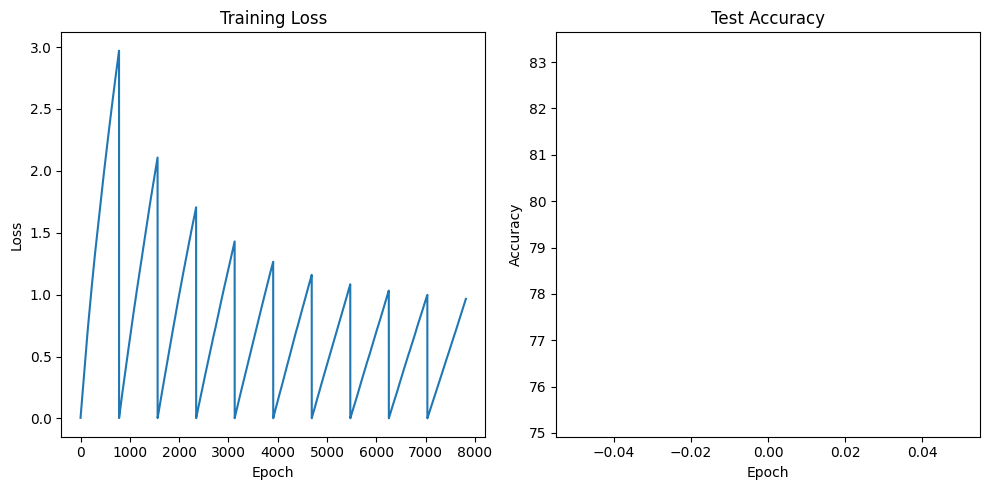

In [ ]:
import matplotlib.pyplot as plt



plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(test_accuracy_history)
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()
